In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import wandb
import logging

import os

from model.datasets import get_loaders

from model.training import DDPM
from model.utils import plot_images
from model.metrics import fid_score, inception_score

import gc
from tqdm.notebook import tqdm

In [4]:
logging.basicConfig(
    handlers=[logging.FileHandler("ddpm.log", mode='w'), logging.StreamHandler()],
    level=logging.INFO, 
    format='[%(asctime)s] %(message)s',
    datefmt='%H:%M:%S'
 )

In [5]:
wandb.config = {
    "dataset": "cifar10",
    "learning_rate": 2e-6,
    "epochs": 2000,
    "batch_size": 128,
    "ema_decay": 0.9999,
    "grad_clip": 1,
    "warmup": 1000,
    "model_path": "bin/cifar10_.pth",
    "epochs_per_save": 15,
    "epochs_per_sample": 15,
    "num_workers": 8
}

In [5]:
wandb.init(project="diffusion", entity="kkorolev", config=wandb.config)

[02:52:26] Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kkorolev. Use `wandb login --relogin` to force relogin


In [34]:
torch.cuda.empty_cache()
gc.collect()

7087

In [5]:
train_loader = get_loaders(wandb.config['dataset'], batch_size=wandb.config['batch_size'], val_ratio=None, train=True)
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
len(train_loader.dataset), device

Files already downloaded and verified


(50000, device(type='cuda'))

In [6]:
ddpm = DDPM(device)
ddpm.load("bin/cifar10_1740.pth")
#optimizer = optim.SGD(model.parameters(), lr=args.lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda epoch: min(epoch, config['warmup']) / config['warmup'])

[02:47:13] Loaded model from bin/cifar10_1740.pth after 1740 epochs


Loaded model from bin/cifar10_1740.pth after 1740 epochs


In [ ]:
ddpm.train(train_loader, None)

Training epoch 1741/2000:   0%|          | 0/391 [00:00<?, ?it/s]

[05:05:16] epoch: 1741 loss: 0.02750 lr: 2e-06


Training epoch 1742/2000:   0%|          | 0/391 [00:00<?, ?it/s]

[05:08:17] epoch: 1742 loss: 0.02759 lr: 2e-06


Training epoch 1743/2000:   0%|          | 0/391 [00:00<?, ?it/s]

[05:11:17] epoch: 1743 loss: 0.02777 lr: 2e-06


Training epoch 1744/2000:   0%|          | 0/391 [00:00<?, ?it/s]

[05:14:18] epoch: 1744 loss: 0.02738 lr: 2e-06


Training epoch 1745/2000:   0%|          | 0/391 [00:00<?, ?it/s]

[05:17:17] epoch: 1745 loss: 0.02787 lr: 2e-06


Training epoch 1746/2000:   0%|          | 0/391 [00:00<?, ?it/s]

In [9]:
train_loader = get_loaders(wandb.config['dataset'], wandb.config['batch_size'], val_ratio=None, train=True)
num_samples = len(train_loader.dataset)
num_samples

Files already downloaded and verified


50000

In [9]:
batch_images = ddpm.sample(ddpm.ema_sampler, num_samples) 
torch.save(batch_images, 'fake_data_1740.pt')

[19:45:26] Going to sample 390 batches
[19:45:26] Sampling #1 batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
batch_images_2 = ddpm.sample(ddpm.sampler, 128)

[21:04:11] Going to sample 1 batches
[21:04:11] Sampling #1 batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
batch_images.shape

torch.Size([128, 3, 32, 32])

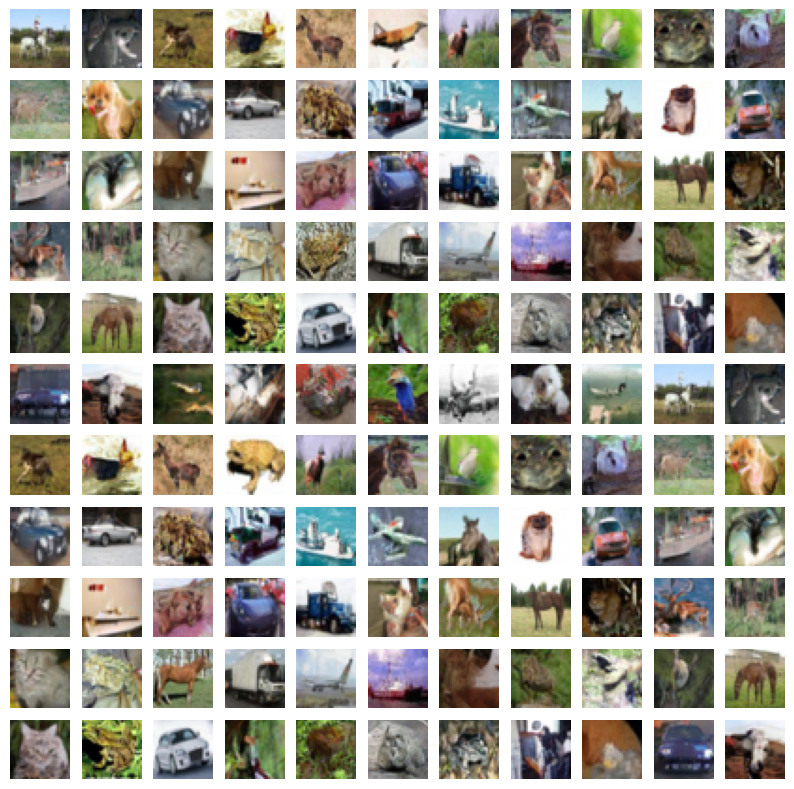

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, title, output_filename=None):
    images = images * 0.5 + 0.5
    np_images = images.numpy()
    np_images = np.clip(np_images, 0, 1)

    fig = plt.figure(figsize=(10,10))

    n_cols = int(np.sqrt(len(images)))
    n_rows = len(images) // n_cols
    index = 0

    for i in range(n_rows):
        for j in range(n_cols):
            fig.add_subplot(n_rows, n_cols, index + 1)
            plt.axis('off')
            plt.imshow(np.transpose(np_images[index], (1, 2, 0)), cmap='gray')
            index += 1
    
    fig.suptitle(title, fontsize=20)

    if output_filename is not None:
        plt.savefig(output_filename)

    plt.show()


#fake_data = torch.load('fake_data.pt')
fake_data = torch.load('fake_data_1740.pt')
plot_images(fake_data[256:256+128,...], '')
#plot_images(batch_images, 'Sampled')

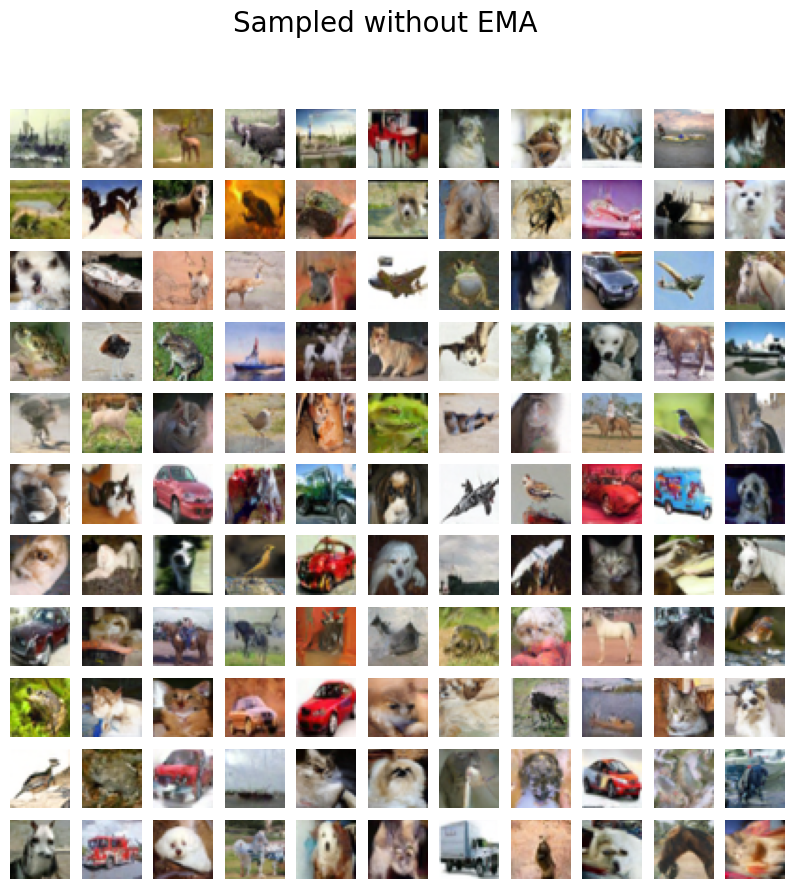

In [14]:
plot_images(batch_images_2, 'Sampled without EMA')

In [10]:
real_data = []

for images, _ in train_loader:
    real_data.append(images)

real_data = torch.cat(real_data, dim=0)
torch.save(real_data, 'real_data.pt')

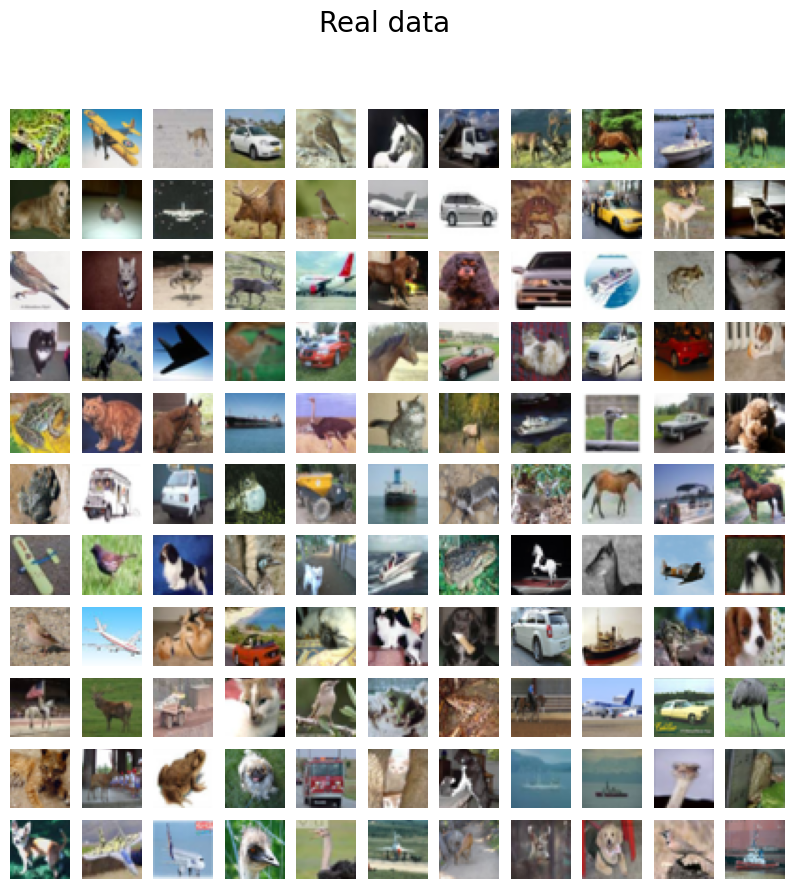

In [11]:
import matplotlib.pyplot as plt

real_data = torch.load('real_data.pt')
plot_images(real_data[:128,...], 'Real data')

In [6]:
def denormalize(images):
    return images * 0.5 + 0.5

device = 'cpu'
real_data = denormalize(torch.load('real_data.pt')).to(device)
fake_data = denormalize(torch.load('fake_data_1740.pt')).to(device)

print("min max real", real_data.min(), real_data.max())
print("min max fake", fake_data.min(), fake_data.max())
print("shapes", real_data.shape, fake_data.shape)

min max real tensor(0.) tensor(1.)
min max fake tensor(0.) tensor(1.)
shapes torch.Size([50000, 3, 32, 32]) torch.Size([50000, 3, 32, 32])


In [7]:
fid = fid_score(real_data, fake_data, feature=2048)
fid

Calculate activations for real data
Calculate activations for fake data
Compute FID


12.915809631347656

In [56]:
inception = inception_score(fake_data)
inception

(tensor(1.0331), tensor(0.0007))